In [18]:
!git clone https://github.com/taslimamindia/NERC.git

Cloning into 'NERC'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 143 (delta 44), reused 128 (delta 31), pack-reused 0
Receiving objects: 100% (143/143), 3.31 MiB | 5.07 MiB/s, done.
Resolving deltas: 100% (44/44), done.


# Importation

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

from nltk import word_tokenize, sent_tokenize, download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.models import Word2Vec

import tensorflow as tf
import os

from keras.utils import to_categorical, pad_sequences

In [16]:
download('wordnet') # for google colab
download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Class define form data.

In [17]:
class Data(object):
    unique_words = {"<PAD>":0}
    unique_ner_tags = {"O":0}
    MAX_LENGTH = 50
    VOCAB_SIZE = 100
    def __init__(self):
        self.sentences = []
        self.sentences_num = None
        self.ner_tags = []
        self.ner_tags_num = None
        self.chunk_tags = []
        self.pos_tags = []
        self.x, self.y = None, None
    def word2idx(self, word:str):
        return Data.unique_words.get(word, None)
    def idx2word(self, index:int):
        for word, value in Data.unique_words.items():
            if index is value: return word
        return None    
    def tag2idx(self, tag):
        return Data.unique_ner_tags.get(tag, None)
    def idx2tag(self, index):
        for tag, value in Data.unique_ner_tags.items():
            if index == value: return tag
        return None
    def unicity(self):
        unique_sent, unique_tag = set(), set()
        [unique_tag.update(tags) for tags in self.ner_tags_num]
        [unique_sent.update(tags) for tags in self.sentences_num]
        max_tags = len(Data.unique_ner_tags)
        max_words = len(Data.unique_words)
        for word in list(unique_sent):
            if Data.unique_words.get(word, None) == None:
                Data.unique_words[word] = max_words
                max_words += 1
        for tag in list(unique_tag):
            if Data.unique_ner_tags.get(tag, None) == None:
                Data.unique_ner_tags[tag] = max_tags
                max_tags += 1


# Loading data

In [4]:
class Loading():
    def __init__(self, path):
        if os.path.exists("../Data/conll2003_english/"): 
            base_file = "../Data/conll2003_english/"
        else:
            base_file = "/content/NERC/Data/conll2003_english/"        
        self.data = Data()
        self.load_sentences(base_file + path)
    def load_sentences(self, filepath):
        tokens, pos_tags, chunk_tags, ner_tags = [], [], [], []
        with open(filepath, 'r') as f:
            for line in f.readlines():
                if (line == ('-DOCSTART- -X- -X- O\n') or line == '\n'):
                    if len(tokens) > 0:
                        self.data.sentences.append(tokens)
                        self.data.pos_tags.append(pos_tags)
                        self.data.chunk_tags.append(chunk_tags)
                        self.data.ner_tags.append(ner_tags)
                        tokens, pos_tags, chunk_tags, ner_tags = [], [], [], []
                else:
                    l = line.split(' ')
                    tokens.append(l[0])
                    pos_tags.append(l[1])
                    chunk_tags.append(l[2])
                    ner_tags.append(l[3].strip('\n'))

# Preprocessing

In [7]:
class Preprocessing():
    def __init__(self, data:Data, text=None, lang="english"):
        self.data = data
        self.text = text
        self.lang = lang
        if text == None:
            self.data.sentences_num = self.data.sentences
            self.data.ner_tags_num = self.data.ner_tags
    
    def tokenize(self):
        if self.text != None:
            sentenses = [word_tokenize(sentence, language=self.lang) for sentence in sent_tokenize(self.text, language=self.lang)]
            self.data.sentences = [[token for token in sentence if token not in stopwords.words(self.lang)] for sentence in sentenses]
            self.data.sentences_num = self.data.sentences
        
    def lowercasing(self):
        self.data.sentences_num = [[word.lower() for word in sentence] for sentence in self.data.sentences_num]
    
    def lemmatize(self):
        lemmatizer = WordNetLemmatizer()
        self.data.sentences_num = [[lemmatizer.lemmatize(word) for word in sentence] for sentence in self.data.sentences_num]
    
    def remove_stopword(self):
        punctuation = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']
        punctuations = stopwords.words(self.lang) + punctuation
        sentences = [[(self.data.sentences_num[i][j], self.data.ner_tags[i][j]) for j in range(len(self.data.sentences_num[i]))] for i in range(len(self.data.sentences_num))]
        sentences = [[(token, tag) for token, tag in sentence if token not in punctuations or tag != "O"] for sentence in sentences]
        self.data.sentences_num = [[token for token, tag in sentence] for sentence in sentences]
        self.data.ner_tags_num = [[tag for token, tag in sentence] for sentence in sentences]

# Vectorization

In [8]:
class Vectorization():
    def __init__(self, data:Data):
        self.data = data
    
    def word2vec(self):
        word2vec_model = Word2Vec(self.data.sentences_num, min_count=1, vector_size=Data.VOCAB_SIZE, window=5)
        self.data.sentences_num = [[word2vec_model.wv[word] for word in sentence] for sentence in self.data.sentences_num]
    
    def padding_x(self):
        self.data.x = pad_sequences(
            sequences=self.data.sentences_num, 
            maxlen=self.data.MAX_LENGTH, 
            dtype="float32", 
            padding="post", 
            value=np.zeros((Data.VOCAB_SIZE,), dtype="float32")
        )
    
    def vectorized_x(self):
        self.word2vec()
        self.padding_x()
        
    def tag2num(self):
        NUM_CLASSES = len(Data.unique_ner_tags)
        self.data.ner_tags_num = [[to_categorical(Data.unique_ner_tags.get(tag), num_classes=NUM_CLASSES) for tag in tags] for tags in self.data.ner_tags_num]
    
    def padding_y(self):
        self.data.y = pad_sequences(
            sequences=self.data.ner_tags_num, 
            maxlen=self.data.MAX_LENGTH,
            padding="post", 
            dtype="float32",
            value=to_categorical(Data.unique_ner_tags.get("O"), num_classes=len(Data.unique_ner_tags))
        )
    
    def vectorized_y(self):
        self.tag2num()
        self.padding_y()

# Main

### Visualization

In [8]:
train = Loading("train.txt").data
test = Loading("test.txt").data
valid = Loading("valid.txt").data

In [9]:
X = []
y = []
[[X.append(word) for word in sentence] for sentence in train.sentences + test.sentences + valid.sentences]
[[y.append(tag) for tag in tags] for tags in train.ner_tags + test.ner_tags + valid.ner_tags]
df = pd.DataFrame({"word":X, "label":y})

In [10]:
hist = df.groupby("label").count()
hist

,word
label,
B-LOC,10645
B-MISC,5062
B-ORG,9323
B-PER,10059
I-LOC,1671
I-MISC,1717
I-ORG,5290
I-PER,6991
O,250660


<Axes: xlabel='class', ylabel='count'>

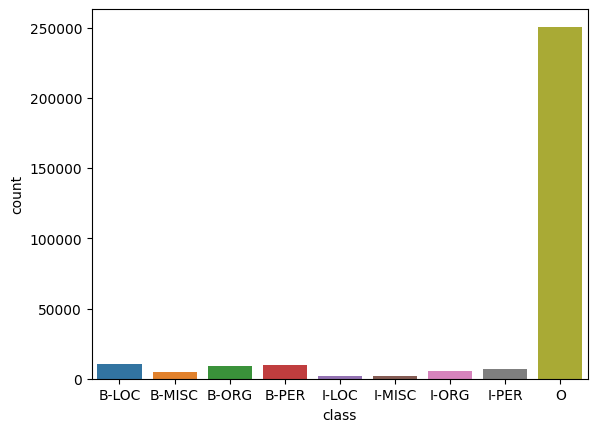

In [11]:
hist = pd.DataFrame({"class":hist.index, "count": hist["word"]})
hist = hist.to_numpy().tolist()
cl = [t[0] for t in hist]
nbr = [t[1] for t in hist]
sns.barplot(data=pd.DataFrame({"class":cl, "count":nbr}), x="class", y="count")

In [12]:
df.describe()

,word,label
count,301418,301418
unique,30289,9
top,",",O
freq,10876,250660


### New input text

In [ ]:
# test_text = Data()

# preprocessing = Preprocessing(data = test_text, text = "Obama is the president of the United States. I am from Guinea, nice to meet you.")
# preprocessing.tokenize()
# preprocessing.lowercasing()
# preprocessing.lemmatize()
# print(test_text.sentences)

# vector = Vectorization(test_text)
# vector.vectorized_x()
# print(test_text.x.shape)

### Parameters

In [10]:
# Hyperparameters
NUM_FILTERS = 256
KERNEL_SIZE = 3
DROPOUT_RATE = 0.6
BATCH_SIZE = 32
EPOCHS = 20

## Evaluation

In [15]:
def evaluation(test:Data, y_predict):
  true, false, total, predict = 0, 0, 0, 0
  x, y, z = test.y.shape
  for i in range(x):
    for j in range(y):
      real_tag = np.argmax(test.y[i][j]) 
      predict_tag = np.argmax(y_predict[i][j])
      if predict_tag == 0: predict +=1
      if real_tag != 0:
        total = total + 1
        if real_tag == predict_tag: true = true + 1
        else: false = false + 1
  print("----------------------- Evaluation -------------------------")
  print(test.y.shape)
  print(predict, x*y)
  print(true, false, total, round(true/total, 3), round(false/total, 3), end="\n\n")

def checkDataset(train, test, valid):    
    print("X_train", train.x.shape)
    print("y_train", train.y.shape, "\n")
    print("X_test", test.x.shape)
    print("y_test", test.y.shape, "\n")    
    print("X_valid", valid.x.shape)
    print("y_valid", valid.y.shape)

def preprocess(data: Data):
    preprocessing = Preprocessing(data=data)
    preprocessing.lowercasing()
    preprocessing.lemmatize()
    preprocessing.remove_stopword()
    data.unicity()
    
def vectorize(data: Data):
    # treat sentences
    vector = Vectorization(data=data)
    vector.vectorized_x()
    vector.vectorized_y()

def main():
    train = Loading("train.txt").data
    test = Loading("test.txt").data
    valid = Loading("valid.txt").data
    preprocess(train)
    preprocess(test)
    preprocess(valid)
    # dico = {}
    # for tags in test.sentences_num + train.sentences_num + valid.sentences_num:
    #   if dico.get(len(tags), None) == None:
    #     dico[len(tags)] = 1
    #   dico[len(tags)] += 1
    # print(sorted(list(dico.items()), key= lambda x: x[1]))
    vectorize(train)
    vectorize(test)
    vectorize(valid)
    checkDataset(train, test, valid)
    return train, test, valid

## CNN model

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D

class Model_CNN:
  def __init__(self):
    # Define the model architecture
    self.model = Sequential()
    self.model.add(Conv1D(128, KERNEL_SIZE, activation='relu', input_shape=(Data.MAX_LENGTH, Data.VOCAB_SIZE), padding='same'))
    self.model.add(Dropout(DROPOUT_RATE))
    self.model.add(Conv1D(64, KERNEL_SIZE, activation='relu', padding='same'))
    self.model.add(Dropout(DROPOUT_RATE))
    self.model.add(Conv1D(32, KERNEL_SIZE, activation='relu', padding='same'))
    self.model.add(Dropout(DROPOUT_RATE))
    self.model.add(Dense(len(Data.unique_ner_tags), activation='softmax'))
    
  def summary(self):
    self.model.summary()
    
  def trainning(self, train:Data, valid:Data=None):
    self.model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    if valid == None:
      self.model.fit(train.x, train.y, batch_size=BATCH_SIZE, epochs=EPOCHS)
    else:
      self.model.fit(train.x, train.y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(valid.x, valid.y))
      
  def testing(self, test:Data):
    return self.model.evaluate(test.x, test.y)
  
  def predicting(self, test:Data):
    return self.model.predict(test.x, batch_size=BATCH_SIZE)

In [21]:
def main_cnn(max_length=None, vocab_size=None):
    if max_length != None: Data.MAX_LENGTH = max_length
    if vocab_size != None : Data.VOCAB_SIZE = vocab_size     
    train, test, valid = main()
    model_cnn = Model_CNN()
    model_cnn.trainning(train, valid)
    model_cnn.testing(test)
    y_predict_cnn = model_cnn.predicting(test)
    evaluation(test, y_predict_cnn)

In [23]:
model_cnn = main_cnn(max_length=100, vocab_size=300)

X_train (14041, 100, 300)
y_train (14041, 100, 9) 

X_test (3453, 100, 300)
y_test (3453, 100, 9) 

X_valid (3250, 100, 300)
y_valid (3250, 100, 9)
Epoch 1/20
439/439 [==============================] - 7s 11ms/step - loss: 0.2315 - accuracy: 0.9712 - val_loss: 0.4304 - val_accuracy: 0.9735
Epoch 2/20
439/439 [==============================] - 3s 8ms/step - loss: 0.1060 - accuracy: 0.9761 - val_loss: 0.4477 - val_accuracy: 0.9735
Epoch 3/20
439/439 [==============================] - 5s 11ms/step - loss: 0.1007 - accuracy: 0.9761 - val_loss: 0.3775 - val_accuracy: 0.9735
Epoch 4/20
439/439 [==============================] - 5s 11ms/step - loss: 0.0974 - accuracy: 0.9763 - val_loss: 0.3722 - val_accuracy: 0.9735
Epoch 5/20
439/439 [==============================] - 4s 9ms/step - loss: 0.0961 - accuracy: 0.9764 - val_loss: 0.3266 - val_accuracy: 0.9735
Epoch 6/20
439/439 [==============================] - 6s 13ms/step - loss: 0.0946 - accuracy: 0.9765 - val_loss: 0.3068 - val_accuracy: 0.9

## Model LSTM

In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

class Model_LSTM:
  def __init__(self):
    # Define the model architecture
    self.model_LSTM = Sequential()
    self.model_LSTM.add(LSTM(256, input_shape=(Data.MAX_LENGTH, Data.VOCAB_SIZE), return_sequences=True, dropout=DROPOUT_RATE))
    self.model_LSTM.add(LSTM(128, return_sequences=True, dropout=DROPOUT_RATE))
    self.model_LSTM.add(LSTM(64, return_sequences=True, dropout=DROPOUT_RATE))
    self.model_LSTM.add(LSTM(32, return_sequences=True, dropout=DROPOUT_RATE))
    self.model_LSTM.add(Dense(len(Data.unique_ner_tags), activation='softmax'))

  def summary(self):
    self.model_LSTM.summary()

  def trainning(self, train:Data, valid:Data=None):
    self.model_LSTM.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    if valid == None:
      self.model_LSTM.fit(train.x, train.y, batch_size=BATCH_SIZE, epochs=EPOCHS)
    else:
      self.model_LSTM.fit(train.x, train.y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(valid.x, valid.y))

  def testing(self, test:Data):
    return self.model_LSTM.evaluate(test.x, test.y)

  def predicting(self, test:Data):
    return self.model_LSTM.predict(test.x, batch_size=BATCH_SIZE)
    

In [13]:
def main_lstm(max_length=None, vocab_size=None):
    if max_length != None: Data.MAX_LENGTH = max_length
    if vocab_size != None : Data.VOCAB_SIZE = vocab_size     
    train, test, valid = main()
    model_lstm = Model_LSTM()
    model_lstm.summary()
    model_lstm.trainning(train, valid)
    model_lstm.testing(test)
    y_predict_lstm = model_lstm.predicting(test)
    evaluation(test, y_predict_lstm)
    return model_lstm

In [ ]:
model_lstm = main_lstm(max_length=200, vocab_size=250)

X_train (14041, 200, 250)
y_train (14041, 200, 9) 

X_test (3453, 200, 250)
y_test (3453, 200, 9) 

X_valid (3250, 200, 250)
y_valid (3250, 200, 9)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200, 256)          519168    
                                                                 
 lstm_1 (LSTM)               (None, 200, 128)          197120    
                                                                 
 lstm_2 (LSTM)               (None, 200, 64)           49408     
                                                                 
 lstm_3 (LSTM)               (None, 200, 32)           12416     
                                                                 
 dense (Dense)               (None, 200, 9)            297       
                                                                 
Total params: 778,409
Trainable params: 

In [ ]:
# def vectorize(data:Data):
#     vector = Vectorization(data=data)
    
#     # # treat sentences
#     # vector.vectorized_x()
#     # vector.vectorized_y()
    
#     # # treat words
#     # vector.word2vec()
#     # vector.tag2num()
#     # Sentences, Tags = [], []
#     # [[Sentences.append(word) for word in sentence] for sentence in data.sentences_num]
#     # [[Tags.append(tag) for tag in tags] for tags in data.ner_tags_num]
#     # data.x, data.y = np.array(Sentences, dtype="float32"), np.array(Tags, dtype="float32")
#     # print(data.x.shape, data.y.shape)

## Tools

In [ ]:
# !pip install tensorflow-addons

In [ ]:
# model_LSTM.save("../Data/model_lstm.keras")

In [ ]:
# model_LSTM = tf.keras.models.load_model("../Data/model_lstm.keras")

In [ ]:
# # np.quantile(sort([1, 2, 3, 8, 7]), 0.50)
# dico = {}
# for tags in test.sentences + train.sentences + valid.sentences:
#   if dico.get(len(tags), None) == None:
#     dico[len(tags)] = 1
#   dico[len(tags)] += 1
# sorted(list(dico.items()), key= lambda x: x[1])

In [ ]:
# entities = dict(zip(Data.unique_ner_tags.keys(), [0 for i in range(len(Data.unique_ner_tags))]))
# for tags in test.ner_tags:
#     for tag in tags:
#         entities[tag] += 1
# is_entities = 0
# is_not_entities = 0
# for tag, nbr in entities.items():
#     if tag != 'O': is_entities += nbr
#     else: is_not_entities += nbr
# print(entities)
# print(is_entities, is_not_entities)

## TF-IDF

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [79]:
def load_tf_idf():
    train = Loading("train.txt").data
    test = Loading("test.txt").data
    valid = Loading("valid.txt").data
    return train, test, valid

def preprocess_tfidf(data:Data):
    preprocessing = Preprocessing(data=data)
    preprocessing.lowercasing()
    preprocessing.lemmatize()
    preprocessing.remove_stopword()
    data.unicity()
    # sentences = [" ".join(sentence) for sentence in data.sentences_num]
    # vectorizer = TfidfVectorizer(max_features=Data.MAX_LENGTH)
    # data.x = vectorizer.fit_transform(sentences).toarray()
    # y = []
    # [[y.append(to_categorical(Data.unique_ner_tags[tag], num_classes=NUM_CLASSES)) for tag in tags] for tags in data.ner_tags]
    # data.y = np.array(y, dtype="float32")

def vectorize_tf_idf(data:Data):
    vectorize = Vectorization(data=data)
    vectorize.padding_x(value="<PAD>", dtype="str")
    vectorize.padding_y(value="O")

def formalize_tfidf(data:Data):
    data.x = data.sentences_num
    data.y = data.ner_tags_num
    x = len(data.x)
    return [" ".join(["".join([data.x[i][j], "__", data.y[i][j]]) for j in range(len(data.x[i]))]) for i in range(x)]

def tf(train:Data, test:Data, valid:Data):
    vectorizer = TfidfVectorizer(
        lowercase=False,
        analyzer="word",
        stop_words=None,
        token_pattern="[\S]+",
        tokenizer=None,
        preprocessor=None    
        )
    data_train = formalize_tfidf(train)
    data_test = formalize_tfidf(test)
    data_valid = formalize_tfidf(valid)
    tfidf_matrix_train = vectorizer.fit_transform(data_train)
    tfidf_matrix_test = vectorizer.transform(data_test)
    tfidf_matrix_valid = vectorizer.transform(data_valid)
    feature_names = vectorizer.get_feature_names_out()
    entities_train = []
    num_keywords = 20
    for doc_index in range(len(data_train)):
        doc_tfidf_scores = tfidf_matrix_train[doc_index].toarray().flatten()
        top_indices = doc_tfidf_scores.argsort()[:-num_keywords - 1:-1]
        doc_entities = [feature_names[i] for i in top_indices]
        entities_train.append(doc_entities)
    print(len(entities_train), len(data_train))
    for i in range(5):
      print(data_train[i])
      print(entities_train[i], "\n")
    

In [80]:
class TF_IDF:
  def __init__(self):
    self.train, self.test, self.valid = load_tf_idf()
    # # Preprocessing
    preprocess_tfidf(self.train)
    preprocess_tfidf(self.test)
    preprocess_tfidf(self.valid)
    # # Vectorization
    # vectorize_tf_idf(self.train)
    # vectorize_tf_idf(self.test)
    # vectorize_tf_idf(self.valid)
    tf(self.train, self.test, self.valid)
tfidf = TF_IDF()

14041 14041
eu__B-ORG reject__O german__B-MISC call__O boycott__O british__B-MISC lamb__O
['lamb__O', 'reject__O', 'boycott__O', 'eu__B-ORG', 'call__O', 'british__B-MISC', 'german__B-MISC', 'corn__O', 'corina__B-PER', 'corini__I-PER', 'corinthian__B-ORG', 'coritiba__B-ORG', 'cork__B-PER', 'cork__I-PER', 'corp__I-ORG', 'corner__O', 'corp.__I-ORG', 'core__O', 'corp__O', 'corporacion__B-ORG'] 

peter__B-PER blackburn__I-PER
['blackburn__I-PER', 'peter__B-PER', 'zyrecha__I-PER', 'corp.__I-ORG', 'corina__B-PER', 'corini__I-PER', 'corinthian__B-ORG', 'coritiba__B-ORG', 'cork__B-PER', 'cork__I-PER', 'corn__O', 'corner__O', 'corp__I-ORG', 'core__O', 'corp__O', 'corporacion__B-ORG', 'corporate__O', 'corporates__O', 'corporation__I-ORG', 'corporation__O'] 

brussels__B-LOC 1996-08-22__O
['brussels__B-LOC', '1996-08-22__O', 'corp.__I-ORG', 'corina__B-PER', 'corini__I-PER', 'corinthian__B-ORG', 'coritiba__B-ORG', 'cork__B-PER', 'cork__I-PER', 'corn__O', 'corner__O', 'zyrecha__I-PER', 'correction__

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.feature_extraction.text import TfidfVectorizer
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Embedding, Conv1D, GlobalMaxPooling1D

# # Load data
# df = pd.read_csv("ner_data.csv", encoding="ISO-8859-1", error_bad_lines=False)
# df = df.fillna(method="ffill")
# sentences = df.groupby("Sentence #")["Word"].apply(list).values
# tags = df.groupby("Sentence #")["Tag"].apply(list).values

# # Perform TF-IDF
# vectorizer = TfidfVectorizer(ngram_range=(1,2))
# X_tfidf = vectorizer.fit_transform([" ".join(sent) for sent in sentences])
# tfidf_vocab = vectorizer.vocabulary_
# tfidf_vocab_inv = {v:k for k,v in tfidf_vocab.items()}
# tfidf_weights = np.asarray(X_tfidf.mean(axis=0)).ravel()

# # Tokenize words
# MAX_NB_WORDS = 20000
# MAX_SEQ_LENGTH = 100
# tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
# tokenizer.fit_on_texts(sentences)
# word_index = tokenizer.word_index

# # Convert words to sequences
# X = tokenizer.texts_to_sequences(sentences)
# X = pad_sequences(X, maxlen=MAX_SEQ_LENGTH)

# # Convert tags to sequences
# tags_index = {"O": 0, "B-LOC": 1, "I-LOC": 2, "B-PER": 3, "I-PER": 4, "B-ORG": 5, "I-ORG": 6}
# y = [[tags_index[tag] for tag in sent] for sent in tags]
# y = pad_sequences(y, maxlen=MAX_SEQ_LENGTH)

# # Split data into train and test sets
# VALIDATION_SPLIT = 0.2
# nb_validation_samples = int(VALIDATION_SPLIT * len(X))
# X_train = X[:-nb_validation_samples]
# y_train = y[:-nb_validation_samples]
# X_test = X[-nb_validation_samples:]
# y_test = y[-nb_validation_samples:]

# # Define CNN model
# model = Sequential()
# model.add(Embedding(MAX_NB_WORDS, Data.VOCAB_SIZE, input_length=MAX_SEQ_LENGTH))
# model.add(Conv1D(128, 5, activation="relu"))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(7, activation="softmax"))
# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# # Train model
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)

# # Predict tags for new sentences
# def predict_tags(sentences):
#     X = tokenizer.texts_to_sequences(sentences)
#     X = pad_sequences(X, maxlen=MAX_SEQ_LENGTH)
#     y_pred = model.predict(X)
#     return [[tfidf_vocab_inv[np.argmax(tfidf_weights * y)] if np.max(tfidf_weights * y) > 0.2 else "O" for y in sent] for sent in y_pred]

# # Test predictions
# sentences_test = ["John lives in New York City.", "Steve Jobs was the founder of Apple."]
# tags_pred = predict_tags(sentences_test)
# print(tags_pred)